In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Define model parameters (see SI, "Parameters estimation")

In [16]:
p = {}

# enzymatic levels and catalytic thresholds
p['H']=50  
p['a']=5
p['b']=20

# prduction rates
p['gP'] = 70.
p['gC']=20

# degradation rates
p['kC']=0.5
p['kPM']= 0.25  # HIPK1-PAGE4 60 h
p['kPH']= 1.0 #1. # CLK2-PAGE4 15 h
p['kPU'] = 0.1 #0.4 # wild type  150 h

# Hipk1-Page4 inhibiting Clk2
p['lC']=10
p['nC']=4
p['P0']=20
p['tau']=1.5/0.001 # dt = 0.001, tau is defined in dt units for practical simulation purposes

# ADT/BAT
p['U'] = 3.
p['U0'] = 1.
p['nU'] = 2.
p['lU'] = 3.
p['l_bat'] = 0.1

gamma_H = np.log(2)/15. # gamma_H is the parameter for time rescaling (see SI, "Dimensionless model")

Define (i) Shifted Hill function and (ii) step function for delay

In [17]:
# shifted Hill function
def HS(x,x0,n,l):
	return (1+l*((x/x0)**n))/(1+((x/x0)**n))

# step function for delay term
def step(x,p):
	return 1 * (x > p['tau'])

Define function for numerical integration of eqs. 1-4 (see Methods - mathematical model)

In [18]:
def integrate_cont(time, p, T_treatment):
    # this function takes integration time array (time), parameter set (p) 
    # and continuous ADT application timepoint (T_treatment) 
    
    # integration timestep and numer of points
	dt = time[1]-time[0]  
	npoints = time.size - 1 

	# define vectors to store results
	PU = np.empty(npoints+1) # WT-PAGE4 
	PM = np.empty(npoints+1) # HIPK1-PAGE4 
	PH = np.empty(npoints+1) # CLK2-PAGE4 
	C = np.empty(npoints+1)  # CLK2
	
	PM[0]=0.
	PH[0]=0.
	C[0]=0.
	PU[0]=0.

	for i in range(1,npoints+1):
		PU[i] = PU[i-1] + dt*( p['gP'] - p['H']*PU[i-1]/(PU[i-1]+p['a']) - p['kPU']*PU[i-1] )
		PM[i] = PM[i-1] + dt*( p['H']*PU[i-1]/(PU[i-1]+p['a']) - C[i-1]*PM[i-1]/(PM[i-1]+p['b']) - p['kPM']*PM[i-1] )
		PH[i] = PH[i-1] + dt*( C[i-1]*PM[i-1]/(PM[i-1]+p['b']) - p['kPH']*PH[i-1] )
        # if treatment, HS(p['U'], p['U0'], p['nU'], p['lU']) is applied
		if i*dt>T_treatment:
			C[i] = C[i-1] + dt*( p['gC']*HS(PM[ i-1-p['tau']*step(i,p)],p['P0'],p['nC'],p['lC'])*HS(p['U'], p['U0'], p['nU'], p['lU']) - p['kC']*C[i-1] )
        # no treatment
		else: 
			C[i] = C[i-1] + dt*( p['gC']*HS(PM[ i-1-p['tau']*step(i,p)],p['P0'],p['nC'],p['lC']) - p['kC']*C[i-1] )

	return PM,PH,C,PU

Control case, no ADT applied

/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


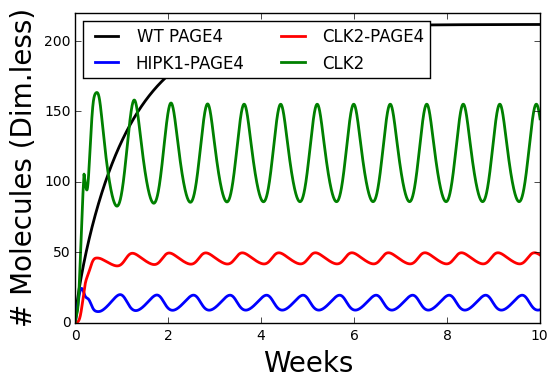

In [19]:
T = 10*(24*7*gamma_H) # 10 weeks of physical time, rescaled to simulation time
dt = 0.001
tm = np.arange(0,T+dt,dt)

PM,PH,C,PU = integrate_cont(tm, p, 12*(24*7*gamma_H)) # take T_treatment larger than total time for control case

# plot result
plt.plot(tm/(24*7*gamma_H),PU, 'k-', linewidth = 2, label = 'WT PAGE4')
plt.plot(tm/(24*7*gamma_H),PM, 'b-', linewidth = 2, label = 'HIPK1-PAGE4')
plt.plot(tm/(24*7*gamma_H),PH, 'r-', linewidth = 2, label = 'CLK2-PAGE4')
plt.plot(tm/(24*7*gamma_H),C, 'g-', linewidth = 2, label = 'CLK2')
plt.ylim([0,220])
plt.xlim([0,10])
plt.legend(loc = 'upper left', ncol=2)
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('# Molecules (Dim.less)', fontsize=20)
plt.show()

Apply continuous ADT after 5 weeks

/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


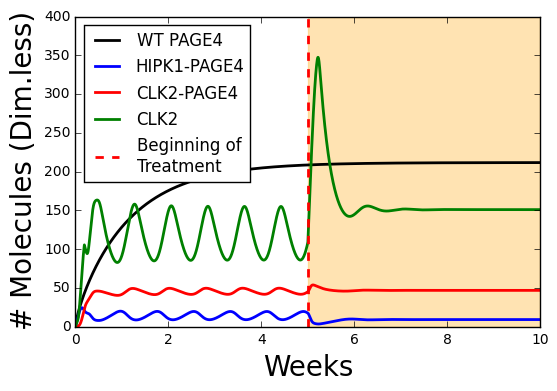

In [20]:
T_treatment = 5*(24*7*gamma_H)

PM,PH,C,PU = integrate_cont(tm, p, T_treatment)

# plot result
plt.plot(tm/(24*7*gamma_H),PU, 'k-', linewidth = 2, label = 'WT PAGE4')
plt.plot(tm/(24*7*gamma_H),PM, 'b-', linewidth = 2, label = 'HIPK1-PAGE4')
plt.plot(tm/(24*7*gamma_H),PH, 'r-', linewidth = 2, label = 'CLK2-PAGE4')
plt.plot(tm/(24*7*gamma_H),C, 'g-', linewidth = 2, label = 'CLK2')
plt.plot( (T_treatment/(24*7*gamma_H), T_treatment/(24*7*gamma_H)), (0,400), 'r--',linewidth=2 , label = 'Beginning of\nTreatment')
plt.fill_betweenx( (0,400), T_treatment/(24*7*gamma_H), 10, color = 'Orange', alpha = 0.3 )
plt.xlim([0,10])
plt.legend(loc = 'upper left')
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('# Molecules (Dim.less)', fontsize=20)
plt.show()

Modify integration function for intermittent ADT 

In [21]:
def integrate_interm(time, p, T_on, T_off):
    # same as integrate_cont, T_on vector marks time points of application of ADT and 
    # T_off vector marks time points when ADT is removed
    
	dt = time[1]-time[0]  
	npoints = time.size - 1 

	PU = np.empty(npoints+1)
	PM = np.empty(npoints+1) 
	PH = np.empty(npoints+1) 
	C = np.empty(npoints+1)
	
	PM[0]=0.
	PH[0]=0.
	C[0]=0.
	PU[0]=0.

	for i in range(1,npoints+1):
		PU[i] = PU[i-1] + dt*( p['gP'] - p['H']*PU[i-1]/(PU[i-1]+p['a']) - p['kPU']*PU[i-1] )
		PM[i] = PM[i-1] + dt*( p['H']*PU[i-1]/(PU[i-1]+p['a']) - C[i-1]*PM[i-1]/(PM[i-1]+p['b']) - p['kPM']*PM[i-1] )
		PH[i] = PH[i-1] + dt*( C[i-1]*PM[i-1]/(PM[i-1]+p['b']) - p['kPH']*PH[i-1] )
		if (i*dt>T_on[0] and i*dt<T_off[0]) or ( i*dt>T_on[1] and i*dt<T_off[1] ) or ( i*dt>T_on[2] and i*dt<T_off[2] ):
			C[i] = C[i-1] + dt*( p['gC']*HS(PM[ i-1-p['tau']*step(i,p)],p['P0'],p['nC'],p['lC'])*HS(p['U'], p['U0'], p['nU'], p['lU']) - p['kC']*C[i-1] )
		else:
			C[i] = C[i-1] + dt*( p['gC']*HS(PM[ i-1-p['tau']*step(i,p)],p['P0'],p['nC'],p['lC']) - p['kC']*C[i-1] )

	return PM,PH,C,PU

Time trajectory with intermittent ADT

/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


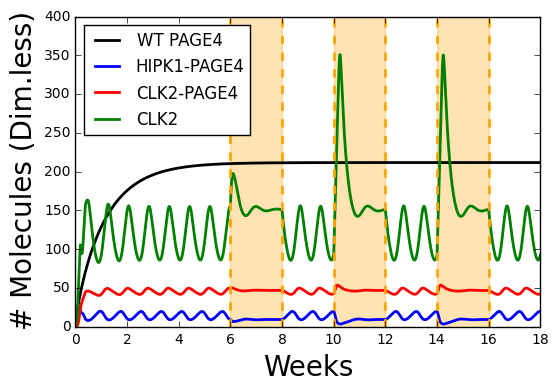

In [22]:
T = 18*(24*7*gamma_H)
tm = np.arange(0,T+dt,dt)
T_on = np.array([6,10,14])*(24*7*gamma_H)
T_off = np.array([8,12,16])*(24*7*gamma_H)

PM,PH,C,PU = integrate_interm(tm, p, T_on, T_off)

#plot results
plt.plot(tm/(24*7*gamma_H),PU, 'k-', linewidth = 2, label = 'WT PAGE4')
plt.plot(tm/(24*7*gamma_H),PM, 'b-', linewidth = 2, label = 'HIPK1-PAGE4')
plt.plot(tm/(24*7*gamma_H),PH, 'r-', linewidth = 2, label = 'CLK2-PAGE4')
plt.plot(tm/(24*7*gamma_H),C, 'g-', linewidth = 2, label = 'CLK2')

plt.plot( (T_on/(24*7*gamma_H), T_on/(24*7*gamma_H)), (0,400), '--', color='Orange',linewidth=2)
plt.plot( (T_off/(24*7*gamma_H), T_off/(24*7*gamma_H)), (0,400), '--', color='Orange',linewidth=2)
plt.fill_betweenx( (0,400), T_on[0]/(24*7*gamma_H), T_off[0]/(24*7*gamma_H), color = 'Orange', alpha = 0.3 )
plt.fill_betweenx( (0,400), T_on[1]/(24*7*gamma_H), T_off[1]/(24*7*gamma_H), color = 'Orange', alpha = 0.3 )
plt.fill_betweenx( (0,400), T_on[2]/(24*7*gamma_H), T_off[2]/(24*7*gamma_H), color = 'Orange', alpha = 0.3 )

plt.xlim([0,18])
plt.legend(loc = 'upper left')
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('# Molecules (Dim.less)', fontsize=20)
plt.show()

4 trajectories of unsynchronized cells

/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


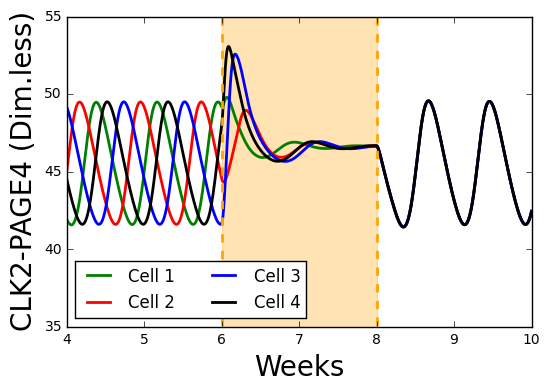

In [23]:
# cell 1

T = 18*(24*7*gamma_H)
dt = 0.001
tm = np.arange(0,T+dt,dt)
T_on = np.array([6,10,14])*(24*7*gamma_H)
T_off = np.array([8,12,16])*(24*7*gamma_H)

PM,PH,C,PU = integrate_interm(tm, p, T_on, T_off)
plt.plot(tm/(24*7*gamma_H),PH, 'g-', linewidth = 2, label = 'Cell 1')


# cell 2

T = 19*(24*7*gamma_H)
dt = 0.001
tm = np.arange(0,T+dt,dt)
T_on = np.array([7,11,15])*(24*7*gamma_H)
T_off = np.array([9,13,17])*(24*7*gamma_H)

PM,PH,C,PU = integrate_interm(tm, p, T_on, T_off)
plt.plot(tm/(24*7*gamma_H)-1,PH, 'r-', linewidth = 2, label = 'Cell 2')


# cell 3

T = 20*(24*7*gamma_H)
dt = 0.001
tm = np.arange(0,T+dt,dt)
T_on = np.array([8,12,16])*(24*7*gamma_H)
T_off = np.array([10,14,18])*(24*7*gamma_H)

PM,PH,C,PU = integrate_interm(tm, p, T_on, T_off)
plt.plot(tm/(24*7*gamma_H)-2,PH, 'b-', linewidth = 2, label = 'Cell 3')


# cell 4

T = 21*(24*7*gamma_H)
dt = 0.001
tm = np.arange(0,T+dt,dt)
T_on = np.array([9,13,17])*(24*7*gamma_H)
T_off = np.array([11,15,19])*(24*7*gamma_H)

PM,PH,C,PU = integrate_interm(tm, p, T_on, T_off)
plt.plot(tm/(24*7*gamma_H)-3,PH, 'k-', linewidth = 2, label = 'Cell 4')

plt.plot( (6,6), (0,400), '--', color='Orange',linewidth=2)
plt.plot( (8,8), (0,400), '--', color='Orange',linewidth=2)
plt.fill_betweenx( (0,400), 6, 8, color = 'Orange', alpha = 0.3 )

plt.ylim([35,55])
plt.xlim([4,10])
plt.legend(loc = 'lower left', ncol=2)
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('CLK2-PAGE4 (Dim.less)', fontsize=20)
plt.show()

Modify integration function for BAT

In [24]:
def integrate_BAT(time, p, T_ADT, T_BAT):
    # same as integrate_interm, T_BAT marks beginning of treatment and T_ADT marks end of AR overexpression
    
	dt = time[1]-time[0] 
	npoints = time.size - 1 

	PU = np.empty(npoints+1)
	PM = np.empty(npoints+1) 
	PH = np.empty(npoints+1) 
	C = np.empty(npoints+1)
	
	PM[0]=0.
	PH[0]=0.
	C[0]=0.
	PU[0]=0.

	for i in range(1,npoints+1):
		PU[i] = PU[i-1] + dt*( p['gP'] - p['H']*PU[i-1]/(PU[i-1]+p['a']) - p['kPU']*PU[i-1] )
		PM[i] = PM[i-1] + dt*( p['H']*PU[i-1]/(PU[i-1]+p['a']) - C[i-1]*PM[i-1]/(PM[i-1]+p['b']) - p['kPM']*PM[i-1] )
		PH[i] = PH[i-1] + dt*( C[i-1]*PM[i-1]/(PM[i-1]+p['b']) - p['kPH']*PH[i-1] )
		if i*dt>T_ADT:
			C[i] = C[i-1] + dt*( p['gC']*HS(PM[ i-1-p['tau']*step(i,p)],p['P0'],p['nC'],p['lC'])*HS(p['U'], p['U0'], p['nU'], p['lU']) - p['kC']*C[i-1] )
		elif i*dt>T_BAT:
			C[i] = C[i-1] + dt*( p['gC']*HS(PM[ i-1-p['tau']*step(i,p)],p['P0'],p['nC'],p['lC'])*HS(p['U'], p['U0'], p['nU'], p['l_bat']) - p['kC']*C[i-1] )
		else:
			C[i] = C[i-1] + dt*( p['gC']*HS(PM[ i-1-p['tau']*step(i,p)],p['P0'],p['nC'],p['lC']) - p['kC']*C[i-1] )

	return PM,PH,C,PU

Time trajectory with BAT

/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


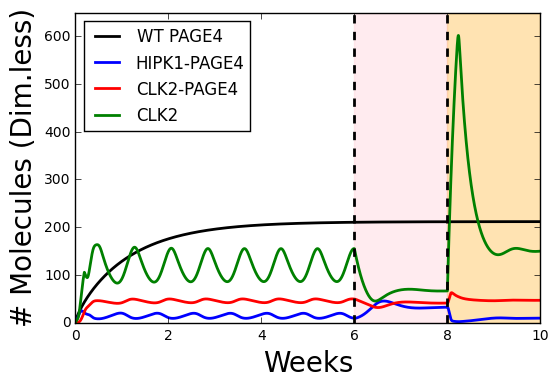

In [25]:
T = 10*(24*7*gamma_H)
tm = np.arange(0,T+dt,dt)
T_BAT = 6*(24*7*gamma_H)
T_ADT = 8*(24*7*gamma_H)

PM,PH,C,PU = integrate_BAT(tm, p, T_ADT, T_BAT)

# plot result
plt.plot(tm/(24*7*gamma_H),PU, 'k-', linewidth = 2, label = 'WT PAGE4')
plt.plot(tm/(24*7*gamma_H),PM, 'b-', linewidth = 2, label = 'HIPK1-PAGE4')
plt.plot(tm/(24*7*gamma_H),PH, 'r-', linewidth = 2, label = 'CLK2-PAGE4')
plt.plot(tm/(24*7*gamma_H),C, 'g-', linewidth = 2, label = 'CLK2')

plt.plot( (T_ADT/(24*7*gamma_H), T_ADT/(24*7*gamma_H)), (0,650), 'k--',linewidth=2 )
plt.plot( (T_BAT/(24*7*gamma_H), T_BAT/(24*7*gamma_H)), (0,650), 'k--',linewidth=2 )
plt.fill_betweenx( (0,650), T_ADT/(24*7*gamma_H), 10, color = 'Orange', alpha = 0.3, label = 'ADT' )
plt.fill_betweenx( (0,650), T_BAT/(24*7*gamma_H), T_ADT/(24*7*gamma_H), color = 'Pink', alpha = 0.3, label = 'BAT' )

plt.ylim([0,650])
plt.xlim([0,10])
plt.legend(loc = 'upper left')
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('# Molecules (Dim.less)', fontsize=20)
plt.show()

4 trajectories of unsynchronized cells and BAT

/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel-4.5.1-py2.7.egg/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


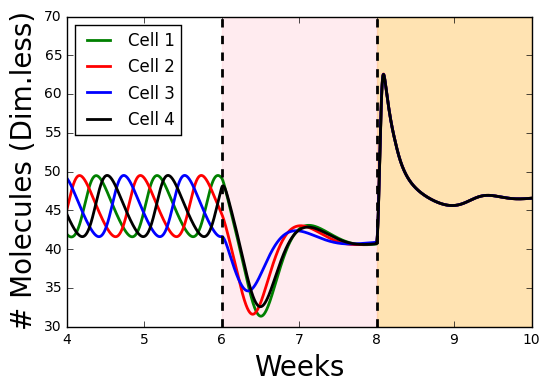

In [26]:
# cell 1
T = 10*(24*7*gamma_H)
dt = 0.001
tm = np.arange(0,T+dt,dt)
T_BAT = 6*(24*7*gamma_H)
T_ADT = 8*(24*7*gamma_H)

PM,PH,C,PU = integrate_BAT(tm, p, T_ADT, T_BAT)
plt.plot(tm/(24*7*gamma_H),PH, 'g-', linewidth = 2, label = 'Cell 1')


# cell 2
T = 11*(24*7*gamma_H)
dt = 0.001
tm = np.arange(0,T+dt,dt)
T_BAT = 7*(24*7*gamma_H)
T_ADT = 9*(24*7*gamma_H)

PM,PH,C,PU = integrate_BAT(tm, p, T_ADT, T_BAT)
plt.plot(tm/(24*7*gamma_H)-1,PH, 'r-', linewidth = 2, label = 'Cell 2')


# cell 3
T = 12*(24*7*gamma_H)
dt = 0.001
tm = np.arange(0,T+dt,dt)
T_BAT = 8*(24*7*gamma_H)
T_ADT = 10*(24*7*gamma_H)

PM,PH,C,PU = integrate_BAT(tm, p, T_ADT, T_BAT)
plt.plot(tm/(24*7*gamma_H)-2,PH, 'b-', linewidth = 2, label = 'Cell 3')


# cell 4
T = 13*(24*7*gamma_H)
dt = 0.001
tm = np.arange(0,T+dt,dt)
T_BAT = 9*(24*7*gamma_H)
T_ADT = 11*(24*7*gamma_H)

PM,PH,C,PU = integrate_BAT(tm, p, T_ADT, T_BAT)
plt.plot(tm/(24*7*gamma_H)-3,PH, 'k-', linewidth = 2, label = 'Cell 4')


plt.plot( (6,6), (30,70), 'k--',linewidth=2 )
plt.plot( (8,8), (30,70), 'k--',linewidth=2 )
plt.fill_betweenx( (30,70), 8, 10, color = 'Orange', alpha = 0.3, label = 'ADT' )
plt.fill_betweenx( (30,70), 6, 8, color = 'Pink', alpha = 0.3, label = 'BAT' )

plt.ylim([30,70])
plt.xlim([4,10])
plt.legend(loc = 'upper left')
plt.xlabel('Weeks', fontsize=20)
plt.ylabel('# Molecules (Dim.less)', fontsize=20)
plt.show()